In [1]:
import mlflow
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata

# data
data = pd.read_parquet("../data/retailrocket/raw/customer_model/")
out_cols = ["user_id", "row_id", "time_step"] + [c for c in data.columns if "target_" in c]
in_cols = [c for c in data.columns if c not in out_cols]
train_data = data.loc[data.time_step>0,in_cols]
test_data = data.loc[data.time_step==0,in_cols]

# model
gbm_reg = mlflow.sklearn.load_model("../data/retailrocket/pipelines/gbm_reg_0/")

# explainer
explainer = shap.Explainer(gbm_reg.predict, train_data, algorithm="permutation")
shap_values = explainer(test_data)

Permutation explainer: 1140it [11:55,  1.58it/s]                          


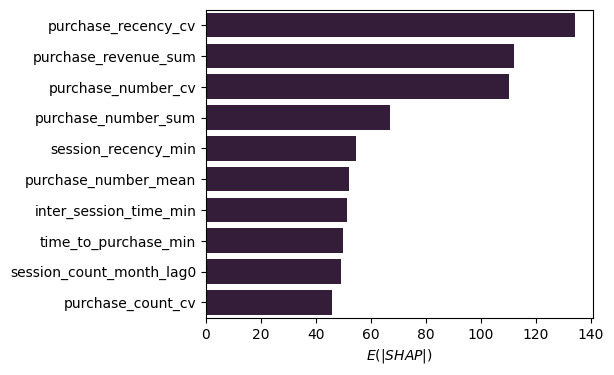

In [2]:
def plot_feature_importance(shap_values, max_features=10, figsize=(5,4)):
    # data
    values = pd.DataFrame(shap_values.values, columns=test_data.columns)
    importance = values.abs().mean().sort_values(ascending=False)\
        .head(max_features).reset_index()
    importance.columns = ["variable", "shap"]

    # plot
    f, a = plt.subplots(1,1, figsize=figsize)
    sns.barplot(x=importance.shap, y=importance.variable,
        color=sns.color_palette("rocket")[0], ax=a);
    a.set_ylabel("");
    a.set_xlabel("$E(|SHAP|)$");

plot_feature_importance(shap_values)    

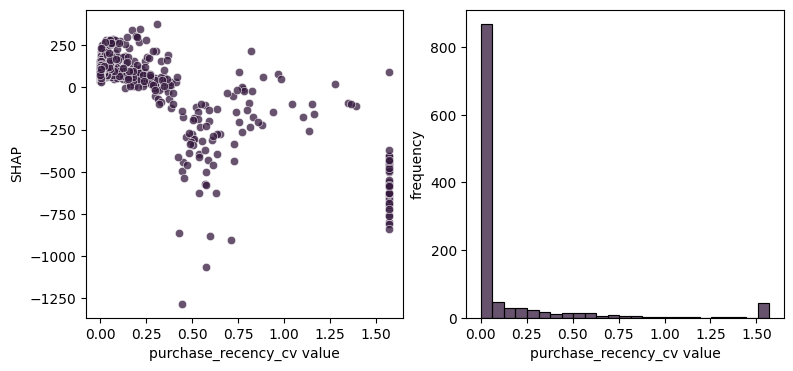

In [30]:
def plot_dependence(shap_values, feature_name=None, xlim=None, bins="auto", figsize=(9,4)):
    # data
    cf = [c==feature_name for c in shap_values.feature_names]
    y = shap_values.values[:,cf].reshape(-1)
    x = shap_values.data[:,cf].reshape(-1)
    # plots
    f, axs = plt.subplots(1,2, figsize=figsize)
    sns.scatterplot(x=x,y=y, ax=axs[0],
        color=sns.color_palette("rocket")[0], alpha=.75)
    sns.histplot(x=x, bins=bins, ax=axs[1],
        color=sns.color_palette("rocket")[0])
    axs[0].set_xlim(xlim)
    axs[0].set_ylabel("SHAP")
    axs[0].set_xlabel(feature_name+" value")
    axs[1].set_xlim(xlim)
    axs[1].set_ylabel("frequency")
    axs[1].set_xlabel(feature_name+" value")
    return None

plot_dependence(shap_values, "purchase_recency_cv", bins=25, xlim=None)

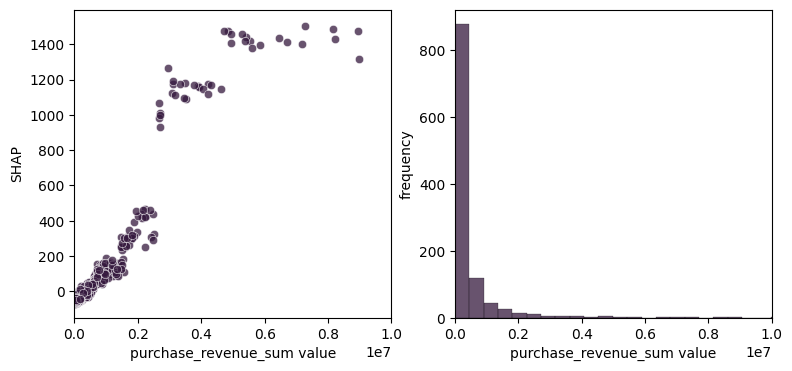

In [4]:
plot_dependence(shap_values, "purchase_revenue_sum", bins=125, xlim=(-100,10**7))    

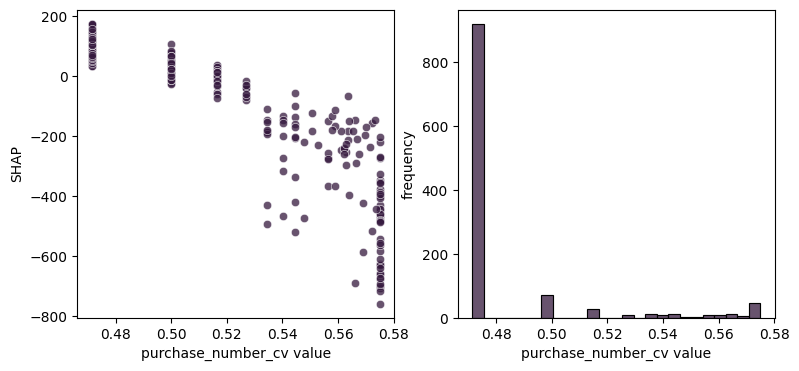

In [5]:
plot_dependence(shap_values, "purchase_number_cv", bins=25, xlim=None)    

In [6]:
def set_lims(mat, lims):
    if lims is None:
        return mat
    else:
        mat[(mat<lims[0])|(mat>lims[1])] =  np.nan
        return mat

def plot_interactions(shap_values, feature_name1=None, feature_name2=None,
    tiles=100, limits=None, figsize=(10,8)):

    c1 = [c==feature_name1 for c in shap_values.feature_names]
    c2 = [c==feature_name2 for c in shap_values.feature_names]
    shv = np.sum(shap_values.values[:,np.logical_or(c1,c2)], axis=1)
    fv1 = shap_values.data[:,c1].reshape(-1)
    fv2 = shap_values.data[:,c2].reshape(-1)

    plotx, ploty = np.meshgrid(
        np.linspace(np.min(fv1),np.max(fv1),tiles),
        np.linspace(np.min(fv2),np.max(fv2),tiles))
    plotz = griddata((fv1,fv2), shv, (plotx, ploty))

    if limits is not None:
        if "x" in limits.keys():
            plotx = set_lims(plotx, limits["x"])
        if "y" in limits.keys():
            ploty = set_lims(ploty, limits["y"])
        if "z" in limits.keys():
            plotz = set_lims(plotz, limits["z"])

    f = plt.figure(figsize=figsize)
    ax = f.add_subplot(111, projection="3d")
    ax.plot_surface(plotx, ploty, plotz, cmap="rocket");
    ax.set_xlabel(feature_name1, labelpad=6);
    ax.set_ylabel(feature_name2, labelpad=6);
    ax.set_zlabel("SHAP", labelpad=6);
    f.tight_layout();
    return None

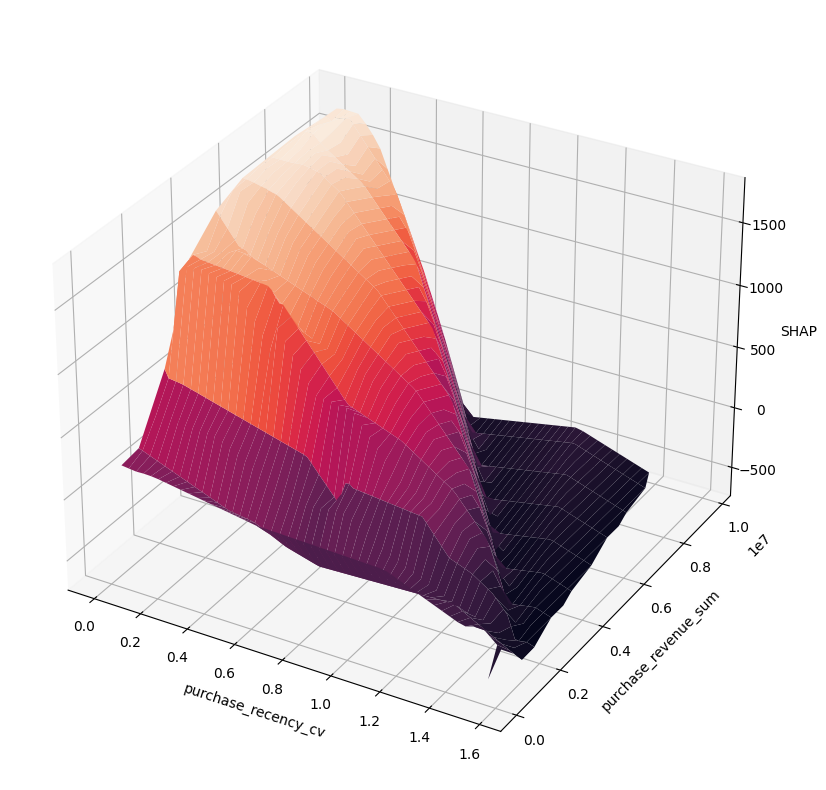

In [7]:
plot_interactions(shap_values, "purchase_recency_cv", "purchase_revenue_sum",
    limits={"y":(-100,10**7), "z":(-2500,2500)})

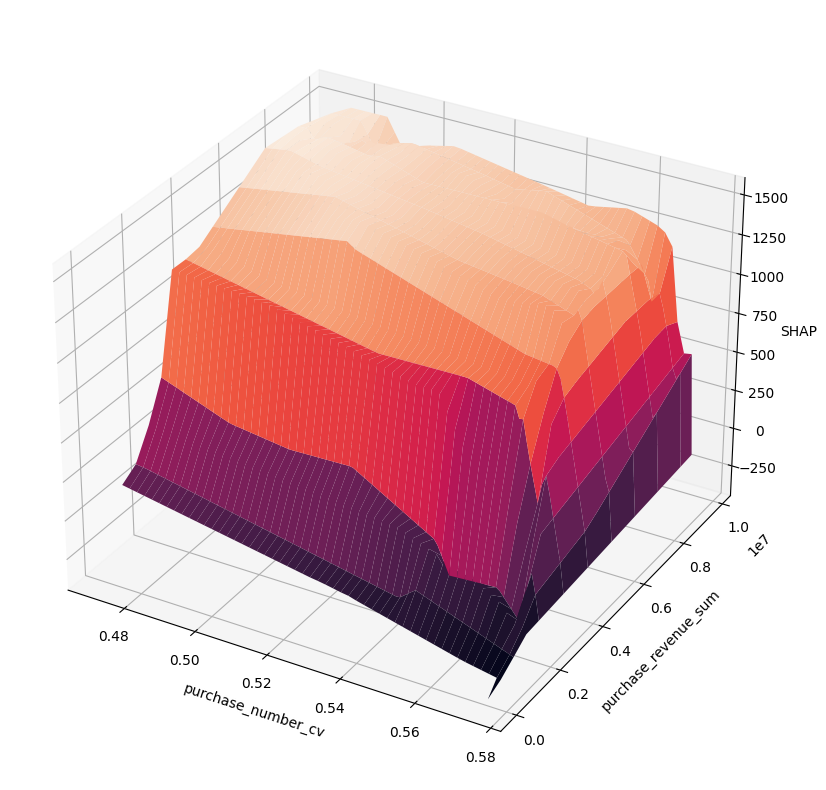

In [8]:
plot_interactions(shap_values, "purchase_number_cv", "purchase_revenue_sum",
    tiles=100, limits={"y":(-100,10**7), "z":(-2500,2500)})

<AxesSubplot:>

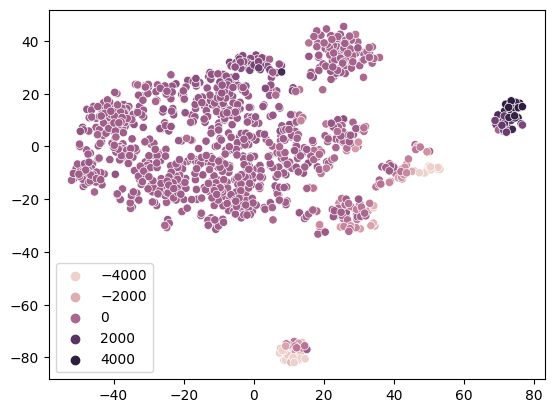

In [27]:
from sklearn.manifold import TSNE

tsne =  TSNE(perplexity=20, learning_rate=75, n_iter=2000, init="random")
shap_transformed = tsne.fit_transform(shap_values.values)
shap_total = np.sum(shap_values.values, axis=1)
sns.scatterplot(x=shap_transformed[:,0],y=shap_transformed[:,1],
    hue=shap_total, hue_norm=(-3000,3000))

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
FixedFormatter should only be used together with FixedLocator


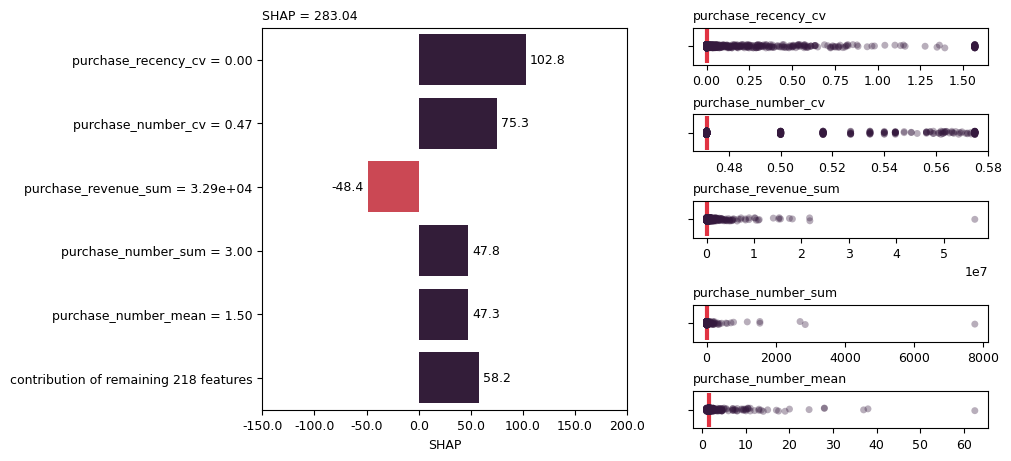

In [642]:
%matplotlib inline

def plot_individual(shap_values, row, max_features=5, shap_xlim=(-200,250)):

    # data
    shap_row = pd.DataFrame(shap_values.values[row,:].reshape(1,-1),
        columns=shap_values.feature_names, index=["shap"]).T
    feature_names = shap_row.abs().sort_values("shap", ascending=False).head(max_features).index
    feature_comp_names = [i for i in shap_row.index if i not in feature_names]
    complement_shap = shap_row.loc[feature_comp_names,:].sum()
    complement_shap.name = f"contribution of remaining {len(feature_comp_names)} features"
    total_shap = shap_row.sum()
    total_shap.name = "shap expected"
    feature_shaps = shap_row.loc[feature_names,:]\
        .append(complement_shap, ignore_index=False)
    feature_shaps = pd.DataFrame(feature_shaps).reset_index()\
        .rename(columns={"index":"name"})
    feature_values = pd.DataFrame(shap_values.data,
        columns=shap_values.feature_names)
    feature_values.loc[row,feature_names]
    feature_values = feature_values.loc[row,feature_names]
    feature_labels = [feature_values.index[i]+" = {:.2f}".format(v)
        if np.abs(v)<10000 else feature_values.index[i]+" = {:.2e}".format(v)
            for i,v in enumerate(feature_values)]+[complement_shap.name]


    plt.rcParams.update({"font.size": 9, "axes.titlesize":9})
    f = plt.figure(constrained_layout=True, figsize=(10, 4.5))
    subfigs = f.subfigures(1, 2, wspace=0.07, width_ratios=[2, 1])

    # left plot
    
    cust_pal = {feature_shaps.name[v]:sns.color_palette("rocket")[0]\
        if feature_shaps.shap[v]>0 else sns.color_palette("rocket")[3]\
            for v in feature_shaps.index}
    la = subfigs[0].subplots(1,1)    
    a = sns.barplot(data=feature_shaps, x="shap", y="name",
        palette=cust_pal, ax=la)
    a.set_title("SHAP = {:.2f}".format(total_shap.values[0]),
        loc="left")
    a.set_ylabel("");
    a.set_yticklabels(feature_labels)
    a.set_xlabel("SHAP");
    a.set_xlim(shap_xlim);
    a.set_xticklabels(a.get_xticks());
    for container in a.containers:
        a.bar_label(container, fmt="%.1f", padding=3)

    # right plot
    feature_values = pd.DataFrame(shap_values.data,
        columns=shap_values.feature_names)        
    ra = subfigs[1].subplots(5,1)    
    for i, a in enumerate(ra.flat):
        a = sns.stripplot(data=feature_values, x=feature_names[i],
            color=sns.color_palette("rocket")[0], alpha=.35, ax=a)
        a.vlines(feature_values.loc[row, feature_names[i]], -1, 1,
            color=sns.color_palette("rocket")[3], linestyles="solid", linewidths=3)
        a.set_xlabel("");
        a.set_title(feature_names[i], loc="left");
        #a.set_xticklabels(np.round(a.get_xticks(),1), fontsize=9);
    plt.rcParams.update(plt.rcParamsDefault)


plot_individual(shap_values,5,5,(-150,200))

In [ ]:
# GLOBAL
# FEATURE IMPORTANCE
# top 5 most influential features - DONE
# DIRECTION AND INTERACTION
# top 3 most influential features & direction - DONE
# top 2 interactions - DONE
# OBSERVATIONS
# clustering observation on SHAPs, find good no of clusters - TBD

# LOCAL
# describe cluster centers with SHAP - DONE
# add additional properties - DONE